In [1]:
import pandas as pd
import pylab as plt
import seaborn as sns
import numpy as np

%matplotlib inline

datapath="/home/felix/spiced/03_week/data/"

In [2]:
df = pd.read_csv(datapath+'bike_train.csv', parse_dates=True, index_col=0)

#### Split dataset

In [3]:
from sklearn.model_selection import train_test_split
df_train,df_test=train_test_split(df)

df_train.sort_index(inplace=True)
df_test.sort_index(inplace=True)


In [4]:
# define functions for preprocessing

def preprocess(df):
    df["weather"].replace(4,3, inplace=True)
    df["hour"]=[i.hour for i in df.index]
    df["dayname"]=[i.day_name() for i in df.index]
    df["year"]=[i.year for i in df.index]
    df["month"]=[i.month for i in df.index]
    return df


def convert_hour_to_cat(df):
    df["cat_hour"]=pd.cut(df["hour"], [0,6,10,15,20,24],include_lowest=True, labels=["night","morning","noon","afternoon","night2"])
    df.loc[df["cat_hour"]=="night2","cat_hour"]="night"
    return df

def drops(df):
    df=df.drop(["holiday", "hour", "registered", "casual"], axis=1)
    return df


In [5]:
# Define Function Transformer
from sklearn.preprocessing import FunctionTransformer

expand_features=FunctionTransformer(preprocess, feature_names_out="one-to-one")
add_cat_hour=FunctionTransformer(convert_hour_to_cat, feature_names_out="one-to-one")
dropsFT=FunctionTransformer(drops, feature_names_out="one-to-one")


In [6]:
# create column Transformer Pipeline

from sklearn.pipeline import Pipeline

preprocessing_steps = [('expander',expand_features), 
                       ('adcath', add_cat_hour),
                       ('drop', dropsFT)]

Preprocessing_transformer=Pipeline(preprocessing_steps)

dfft=Preprocessing_transformer.fit_transform(df_train)


In [7]:
dfft.columns

Index(['season', 'workingday', 'weather', 'temp', 'atemp', 'humidity',
       'windspeed', 'count', 'dayname', 'year', 'month', 'cat_hour'],
      dtype='object')

In [8]:
cat_features   = ['season', 'workingday', 'dayname', 'cat_hour', 'weather']
num_features   = ['temp', 'atemp', 'humidity', 'windspeed',  'year', 'month' ]
scale_features = ['temp', 'atemp', 'humidity', 'windspeed']

In [9]:
from sklearn.preprocessing import OneHotEncoder

In [10]:
from sklearn.preprocessing import OneHotEncoder
categorical_steps = [('onehot', OneHotEncoder(handle_unknown='ignore'))]
categorical_transformer = Pipeline(categorical_steps)


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
numeric_steps = [('imputer', SimpleImputer(strategy='median')), 
                 ('scaler', StandardScaler())]
# sub-pipeline 2
numeric_transformer  = Pipeline(numeric_steps)

In [11]:
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
        ('numeric', numeric_transformer, scale_features),
        ('categorical', categorical_transformer, cat_features)])


In [12]:
preprocessor.fit_transform(df_train).shape

(8164, 24)

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier

final_steps = [('custom_preprocessing', Preprocessing_transformer),
     ('preprocessor', preprocessor),
     ('LinReg', LinearRegression())] # instanciation of the model class
     #('RanFor', RandomForestClassifier())] # instanciation of the model class
pipeline = Pipeline(final_steps)

In [14]:
from friendly.jupyter import *
Xtrain=df_train.drop("count", axis=1)
Ytrain=df_train["count"]
pipeline.fit(Xtrain,Ytrain)
print(pipeline.score(Xtrain,Ytrain))

Xtest=df_test.drop("count", axis=1)
Ytest=df_test["count"]

print(pipeline.score(Xtest,Ytest))


from sklearn.metrics import mean_squared_log_error
Y_testpred = pipeline.predict(Xtest)
Y_testpred[Y_testpred<0]=0
Y_testpred=Y_testpred.round().astype(int)

Y_trainpred = pipeline.predict(Xtrain)
Y_trainpred[Y_trainpred<0]=0
Y_trainpred=Y_trainpred.round().astype(int)



#kaggle_score = np.sqrt(mean_squared_log_error(y_true=Ytest, y_pred=Y_testpred))
#print(kaggle_score)


#from sklearn.metrics import  classification_report,accuracy_score

#print(accuracy_score(Ytest, Y_testpred))

friendly_traceback 0.5.57; friendly 0.5.39.
Type 'Friendly' for basic help.
0.5275932499314953
0.5447941645270484


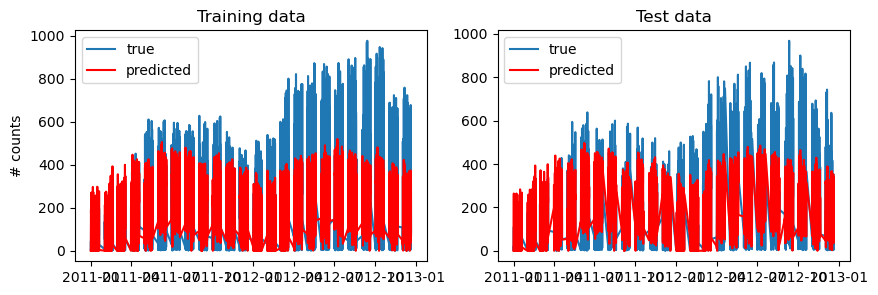

In [15]:

fig=plt.figure(figsize=(10,3))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)

ax1.plot(Ytrain, label="true")
ax1.plot(Ytrain.index,Y_trainpred, "r-", label="predicted")
ax2.plot(Ytest, label="true")
ax2.plot(Ytest.index,Y_testpred, "r-", label="predicted")

ax1.set_ylabel("# counts")

ax1.legend()
ax2.legend()

ax1.set_title("Training data")
ax2.set_title("Test data")

